In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf

# Kaggle-specific: Define paths to dataset
dataset_dir = '/kaggle/input/plant-disease-detection/Dataset_Final'
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')

# Define batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (96, 96)




In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
# train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
#                                                                  shuffle=True,
#                                                                  batch_size=BATCH_SIZE,
#                                                                  image_size=IMG_SIZE,
#                                                                  validation_split=.20,
#                                                                  subset='training',
#                                                                  seed=66)
# validation_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
#                                                                  shuffle=True,
#                                                                  batch_size=BATCH_SIZE,
#                                                                  image_size=IMG_SIZE,
#                                                                  validation_split=.20,
#                                                                  subset='validation',
#                                                                  seed=66)

Found 6744 files belonging to 19 classes.
Found 1348 files belonging to 19 classes.
Found 900 files belonging to 19 classes.


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
# from tensorflow.keras.preprocessing import image_dataset_from_directory
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming you've defined your image augmentation
# rotation_augmentation = Sequential([preprocessing.RandomRotation(factor=0.2)], name="rotation_augmentation")
# translation_augmentation = Sequential([preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)], name="translation_augmentation")
# zoom_augmentation = Sequential([preprocessing.RandomZoom(height_factor=0.2)], name="zoom_augmentation")

# # Load some sample images from your dataset
# # Update the directory accordingly
# folder_dir = '/content/resized/train'
# sample_dataset = image_dataset_from_directory(
#     directory=folder_dir,
#     shuffle=True,
#     image_size=(SIZE, SIZE),
#     batch_size=1,
#     label_mode='categorical',
#     seed=22
# )

# # Apply each augmentation and display the results
# for images, labels in sample_dataset.take(1):
#     original_image = images[0].numpy()

#     # Display the original image
#     plt.figure(figsize=(10, 10))
#     plt.subplot(1, 4, 1)
#     plt.imshow(original_image.astype("uint8"))
#     plt.title("Original Image")
#     plt.axis("off")

#     # Display the rotated image
#     rotated_image = rotation_augmentation(images)[0].numpy()
#     plt.subplot(1, 4, 2)
#     plt.imshow(rotated_image.astype("uint8"))
#     plt.title("Rotated Image")
#     plt.axis("off")

#     # Display the translated image
#     translated_image = translation_augmentation(images)[0].numpy()
#     plt.subplot(1, 4, 3)
#     plt.imshow(translated_image.astype("uint8"))
#     plt.title("Translated Image")
#     plt.axis("off")

#     # Display the zoomed image
#     zoomed_image = zoom_augmentation(images)[0].numpy()
#     plt.subplot(1, 4, 4)
#     plt.imshow(zoomed_image.astype("uint8"))
#     plt.title("Zoomed Image")
#     plt.axis("off")

#     plt.show()


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomContrast(factor=0.1),
        layers.RandomBrightness(factor=0.1),

    ]
)

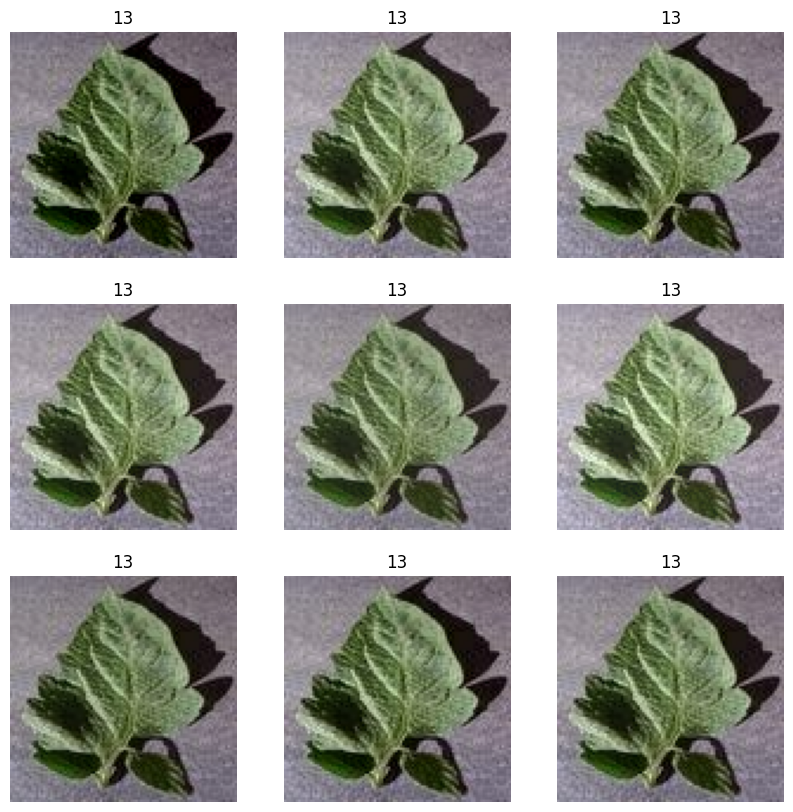

In [ ]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
from tensorflow.keras.applications import Xception, VGG19, ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

no_of_classes = 19
SIZE = 96

# Data augmentation
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal", seed=42),  # Add a seed for reproducibility
    keras.layers.RandomRotation(0.1, seed=42),     # Add a seed for reproducibility
    keras.layers.RandomZoom(0.1, seed=42),        # Add a seed for reproducibility
], name='data_augmentation') # Add a name for the layer

# Rescaling function for input normalization
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)

# Function to add base models to the ensemble
def add_base_model(base_model):
    inputs = keras.Input(shape=(SIZE, SIZE, 3))
    x = data_augmentation(inputs)
    x = scale_layer(x)
    x = base_model(x, training=False)  # Ensure batchnorm layers remain in inference mode
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Regularization with dropout
    x = Dense(512, activation="relu")(x)
    return inputs, x

# Create base models (without top layers) and freeze them
base_model1 = Xception(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))
base_model2 = VGG19(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))
base_model3 = ResNet152V2(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))

base_model1.trainable = False
base_model2.trainable = False
base_model3.trainable = False


# Get the inputs and outputs for each base model
input_1, output_1 = add_base_model(base_model1)
input_2, output_2 = add_base_model(base_model2)
input_3, output_3 = add_base_model(base_model3)

# Concatenate the outputs from all models
combined = Concatenate()([output_1, output_2, output_3])

# Add dense layers on top of the concatenated outputs
x = Dropout(0.5)(combined)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(no_of_classes, activation="softmax")(x)

# Create the ensemble model
ensemble_model = Model(inputs=[input_1, input_2, input_3], outputs=outputs)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)


In [ ]:
ensemble_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model (Transfer Learning)
def create_dataset(ds):
  """
  This function creates a dataset that yields tuples of images for each input.
  """
  return ds.map(lambda image, label: ((image, image, image), label))

history = ensemble_model.fit(
    create_dataset(train_dataset),  # Pass a dataset yielding tuples
    epochs=100,
    validation_data=create_dataset(validation_dataset),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 78s 220ms/step - accuracy: 0.1241 - loss: 2.8226 - val_accuracy: 0.5059 - val_loss: 1.3469 - learning_rate: 0.0010
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 37s 177ms/step - accuracy: 0.4686 - loss: 1.4104 - val_accuracy: 0.6736 - val_loss: 0.8984 - learning_rate: 0.0010
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 38s 178ms/step - accuracy: 0.5730 - loss: 1.1110 - val_accuracy: 0.7047 - val_loss: 0.8007 - learning_rate: 0.0010
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 38s 179ms/step - accuracy: 0.6323 - loss: 0.9822 - val_accuracy: 0.7136 - val_loss: 0.7570 - learning_rate: 0.0010
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 38s 180ms/step - accuracy: 0.6657 - loss: 0.8821 - val_accuracy: 0.7493 - val_loss: 0.6564 - learning_rate: 0.0010
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.6696 - loss: 0.8363 - val_accuracy: 0.7485 - val_loss: 0.6341 - learning_rate: 0.0010
Epoch 7/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accura

In [ ]:
# Evaluate the model
def create_dataset(ds):
  """
  This function creates a dataset that yields tuples of images for each input.
  """
  return ds.map(lambda image, label: ((image, image, image), label)) # Replicate the image for each of the three inputs

scores = ensemble_model.evaluate(create_dataset(test_dataset)) # Ensure the test dataset yields a tuple of 3 image tensors

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.8899 - loss: 0.3076


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-12, verbose=1)

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)


In [ ]:
# Unfreeze the base models for fine-tuning
base_model1.trainable = True
base_model2.trainable = True
base_model3.trainable = True

# Compile the model again with a lower learning rate for fine-tuning
ensemble_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Train the model (Fine-tune )
def create_dataset(ds):
  """
  This function creates a dataset that yields tuples of images for each input.
  """
  return ds.map(lambda image, label: ((image, image, image), label))
# Fine-tune the model
history_fine = ensemble_model.fit(
    create_dataset(train_dataset),  # Pass a dataset yielding tuples
    epochs=100,
    validation_data=create_dataset(validation_dataset),
    callbacks=[reduce_lr] #, early_stopping
)

Epoch 1/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 275s 661ms/step - accuracy: 0.6612 - loss: 1.0134 - val_accuracy: 0.8093 - val_loss: 0.5321 - learning_rate: 1.0000e-05
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 130s 616ms/step - accuracy: 0.7616 - loss: 0.6563 - val_accuracy: 0.8034 - val_loss: 0.5412 - learning_rate: 1.0000e-05
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 130s 615ms/step - accuracy: 0.8031 - loss: 0.5356 - val_accuracy: 0.8205 - val_loss: 0.4793 - learning_rate: 1.0000e-05
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 130s 615ms/step - accuracy: 0.8162 - loss: 0.4964 - val_accuracy: 0.8398 - val_loss: 0.4349 - learning_rate: 1.0000e-05
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 130s 616ms/step - accuracy: 0.8412 - loss: 0.4244 - val_accuracy: 0.8494 - val_loss: 0.4038 - learning_rate: 1.0000e-05
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 130s 616ms/step - accuracy: 0.8571 - loss: 0.3858 - val_accuracy: 0.8539 - val_loss: 0.4010 - learning_rate: 1.0000e-05
Epoch 7/100
211/211 ━━━━━━━━━━━━━━

In [ ]:
# Evaluate the model
def create_dataset(ds):
  """
  This function creates a dataset that yields tuples of images for each input.
  """
  return ds.map(lambda image, label: ((image, image, image), label)) # Replicate the image for each of the three inputs

fine_tune_scores = ensemble_model.evaluate(create_dataset(test_dataset)) # Ensure the test dataset yields a tuple of 3 image tensors

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9545 - loss: 0.1374


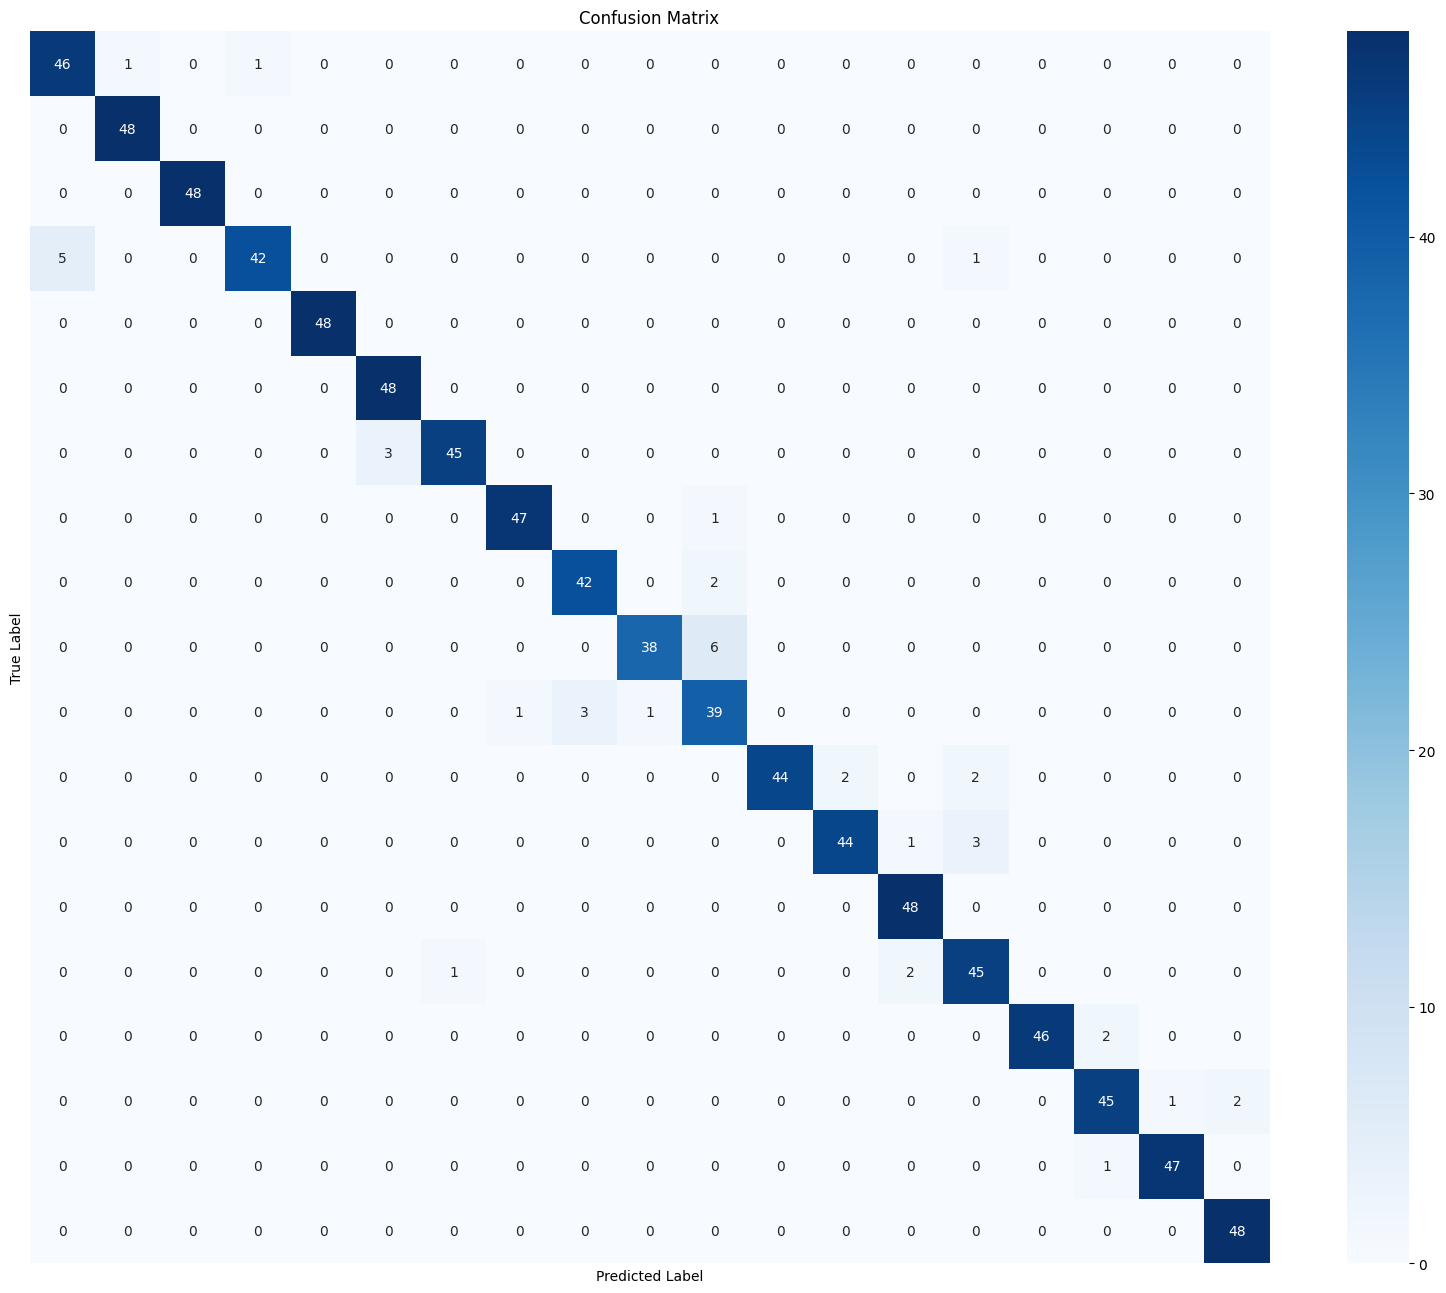

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import os
import pathlib

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow messages

# Manually extract class names from the dataset directory (replace with your test directory path)
test_dir = pathlib.Path('/content/Dataset_Final/test')  # Replace with your test directory path
class_names = np.array([item.name for item in test_dir.glob('*') if item.is_dir()])

# Prepare test dataset for prediction
# test_dataset_unbatched = test_dataset.unbatch().batch(1)  # Unbatch and re-batch for individual predictions
def create_dataset(ds):
  """
  This function creates a dataset that yields tuples of images for each input.
  """
  return ds.map(lambda image, label: ((image, image, image), label)) # Replicate the image for each of the three inputs
test_dataset_unbatched = create_dataset(test_dataset)

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Suppress printing from TensorFlow during prediction
tf.get_logger().setLevel('ERROR')

# Iterate through the test dataset to obtain true and predicted labels
for images, labels in test_dataset_unbatched:
    predictions = ensemble_model.predict(images, verbose=0)  # Use ensemble_model for prediction
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

F1 Score: 0.9527443010269788
Precision: 0.9544111020615352
Recall: 0.9526515151515152
ROC-AUC Score: 0.9993776753614023


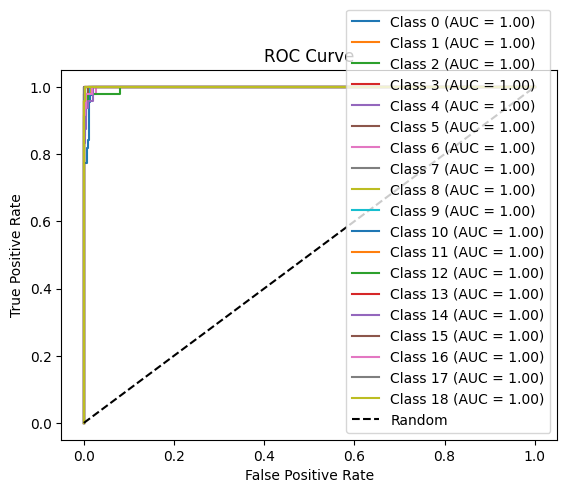

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# After model.fit(...)
# Batch size = 1 for individual predictions
test_dataset = test_dataset.unbatch().batch(1)
nb_classes = 19
y_true = []
y_pred = []

for x_val, y_val in test_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    # Replicate the image data for each of the three inputs
    input_data = (x_val, x_val, x_val)
    # Suppress individual prediction outputs with verbose=0
    y_pred.append(ensemble_model.predict(input_data, verbose=0)[0])  # Append predicted probabilities

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(ensemble_model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open("model.tflite", 'wb') as f:
    f.write(tflite_model)

In [ ]:
!kill -9 -1